In [1]:
import numpy as np
import scipy
from scipy.stats import norm
import random
import statistics as stat
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Price of Call Option function
def get_call( T, r, d, S0,K, sigma):
    if K==0 or T==0 or sigma ==0:
        print('Not a valid input')
    elif d == 0:
        d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)
        call = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        return call
    elif d < 0:
        print('Not a valid dividend input')
    else:
        d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)
        print(d1)
        call = np.exp(-d*T)*S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        return(call)

In [3]:
# BS Delta of a call option
def get_delta_call(T,r,d,S0,K,sigma):
    d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    delta= norm.cdf(d1)
    return delta , d1

,tau,S,action,bs,cash,port,pnl
0,1.000,100.000000,100,6.376274,3.997262,3.997262,-2.379012
1,0.889,112.405330,buy,14.410200,-108.408068,1.476985,-12.933215
2,0.778,111.138782,hold stock,13.093100,-108.408068,2.730714,-10.362386
3,0.667,111.311126,hold stock,12.908535,-108.408068,2.903057,-10.005478
4,0.556,108.213302,hold stock,10.102812,-108.408068,-0.194767,-10.297579
5,0.445,105.421457,hold stock,7.605628,-108.408068,-2.986612,-10.592240
6,0.334,115.398841,hold stock,15.658803,-108.408068,6.990773,-8.668030
7,0.223,109.773545,hold stock,10.187230,-108.408068,1.365477,-8.821753
8,0.112,109.444361,hold stock,9.550481,-108.408068,1.036293,-8.514189
9,0.001,109.885053,hold stock,9.885053,-108.408068,1.476985,-8.408068


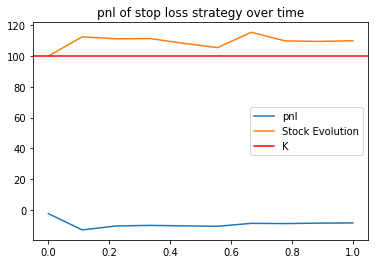

In [6]:
#stop loss buy 1 share when reach K and sell when below
#notional 1
#sell 1 notional of Call option struck at K then use proceeds to cover call when S>=K 
#sell stock when S<K so uncovered call when OTM

#assumed interest rate is 0%
periods=10
time=np.linspace(0.001,1,periods)
tau=time[::-1]
tau 
z=[0]

for i in range (0,len(tau)):
    z.append(np.random.randn())
S=[100]

r=0
d=0
K=100
T=1
sigma=0.16
C0=get_call(T=1, r=0, d=0, S0=100,K=106, sigma=0.16)

action=[]
if S[0]>=K:
    action.append(K)
else:
    action.append(0)

d1=[]

bs=[]
pnl=[]
variance=[]


#generate random stock process
S= [100 ,S[0]*np.exp((r-0.5*sigma**2)/periods + sigma*z[1]/np.sqrt(periods))]
for j in range(1,len(tau)-1):
    S.append(S[j]*np.exp((r-0.5*sigma**2)/periods + sigma*z[j+1]/np.sqrt(periods)))

#stock holdings -> option underwriter:
# buys 1 unit of stock if S=>K for each time period (covered call) *technically buy when S=K and hold S>K
# sells 1 unit of stock if S<K and does nothing provided S stays less than K (uncovered call)
# buying stock at price K (if S>K at time t then technically S=K before time t)
#so make t continuous for better accuracy

for i in range(1,len(S)):
    if S[i]==K:
        action.append('buy')
    if S[i]>K:
        if action[i-1]=='buy':
            action.append('hold stock')
        elif action[i-1]==('hold stock'):
            action.append('hold stock')
        else:
            action.append('buy')
    else:
        if action[i-1]=='sell':
            action.append('do nothing')
                
        elif action[i-1]=='do nothing':
            action.append('do nothing')
        elif action[i-1]==0:
            action.append('do nothing')
            
        else:
            action.append('sell')
    
#generate BS Call price evolution
for u in range(0,periods):
    bs.append(get_call(tau[u], r, d, S[u],K, sigma))

# cash evolution
cash=[C0]
for c in range(1,periods):
    if action[c]=='do nothing':
        cash.append(cash[c-1])
    elif action[c]=='buy':
        cash.append(cash[c-1]-S[c])
    elif action[c]=='hold stock':
        cash.append(cash[c-1])
    else:
        cash.append(cash[c-1]+S[c])
    
#value of portfolio (cash+stock value if are holding stock)
portfolio=[cash[0]]
for p in range(1,periods):
    if action[p]=='do nothing':
        portfolio.append(cash[p])
    elif action[p]=='buy':
        portfolio.append(cash[p]+S[c])
    elif action[p]=='hold stock':
        portfolio.append(cash[p]+S[p])
    else:
        portfolio.append(cash[p]-S[c])

#generate pnl for each time interval        
for h in range(0,periods):
    pnl.append(portfolio[h]-bs[h])

plt.plot(time,pnl,label='pnl')
plt.title('pnl of stop loss strategy over time')
plt.legend()


plt.plot(time,S,label='Stock Evolution')
plt.axhline(y=K, color='r', linestyle='-',label='K')
plt.legend()

s = {'tau':tau, 'S':S,'action':action,'bs':bs,'cash':cash,'port':portfolio,'pnl':pnl}
pd.DataFrame(s)


 

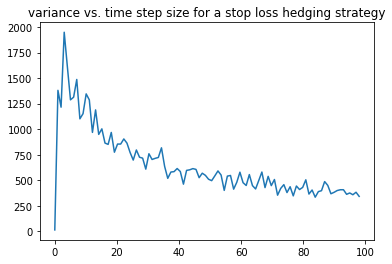

In [21]:
#other stop loss buy 1 share when reach K and sell when below
#notional 1
#sell 1 notional of Call option struck at K then use proceeds to cover call when S>=K 
#sell stock when S<K so uncovered call when OTM
mc_var=[]
#assumed interest rate is 0%
for mc in range(1,30):
    variance=[]

    for periods in range(2,100):
        time=np.linspace(0.001,1,periods)
        tau=time[::-1]
        tau 
        z=[0]

        for i in range (0,len(tau)):
            z.append(np.random.randn())
        S=[100]

        r=0
        d=0
        K=100
        T=1
        sigma=0.16
        C0=get_call(T=1, r=0, d=0, S0=100,K=106, sigma=0.16)

        action=[]
        if S[0]>=K:
            action.append(K)
        else:
            action.append(0)


        bs=[]
        pnl=[]



        #generate random stock process
        S= [100 ,S[0]*np.exp((r-0.5*sigma**2)/periods + sigma*z[1]/np.sqrt(periods))]
        for j in range(1,len(tau)-1):
            S.append(S[j]*np.exp((r-0.5*sigma**2)/periods + sigma*z[j+1]/np.sqrt(periods)))

        #stock holdings -> option underwriter:
        # buys 1 unit of stock if S=>K for each time period (covered call) *technically buy when S=K and hold S>K
        # sells 1 unit of stock if S<K and does nothing provided S stays less than K (uncovered call)
        # buying stock at price K (if S>K at time t then technically S=K before time t)
        #so make t continuous for better accuracy

        for i in range(1,len(S)):
            if S[i]==K:
                action.append('buy')
            if S[i]>K:
                if action[i-1]=='buy':
                    action.append('hold stock')
                elif action[i-1]==('hold stock'):
                    action.append('hold stock')
                else:
                    action.append('buy')
            else:
                if action[i-1]=='sell':
                    action.append('do nothing')

                elif action[i-1]=='do nothing':
                    action.append('do nothing')
                elif action[i-1]==0:
                    action.append('do nothing')

                else:
                    action.append('sell')

        #generate BS Call price evolution
        for u in range(0,periods):
            bs.append(get_call(tau[u], r, d, S[u],K, sigma))

        # cash evolution
        cash=[C0]
        for c in range(1,periods):
            if action[c]=='do nothing':
                cash.append(cash[c-1])
            elif action[c]=='buy':
                cash.append(cash[c-1]-S[c])
            elif action[c]=='hold stock':
                cash.append(cash[c-1])
            else:
                cash.append(cash[c-1]+S[c])

        #value of portfolio (cash+stock value if are holding stock)
        portfolio=[cash[0]]
        for p in range(1,periods):
            if action[p]=='do nothing':
                portfolio.append(cash[p])
            elif action[p]=='buy':
                portfolio.append(cash[p]+S[c])
            elif action[p]=='hold stock':
                portfolio.append(cash[p]+S[p])
            else:
                portfolio.append(cash[p]-S[c])

        #generate pnl for each time interval        
        for h in range(0,periods):
            pnl.append(portfolio[h]-bs[h])


        variance.append(np.var(pnl))
        
    mc_var.append(variance)
   
    
mean_var=[]    
for d in range(0,len(variance)):
    intermediate_list=[]
    for g in range(0,len(mc_var)):
        intermediate_list.append(mc_var[g][d])
    mean_var.append(np.mean(intermediate_list))
    
    
                    
x=np.linspace(0,len(mean_var),len(mean_var))
plt.plot(x,mean_var)
plt.title('variance vs. time step size for a stop loss hedging strategy')
plt.show()
        
    

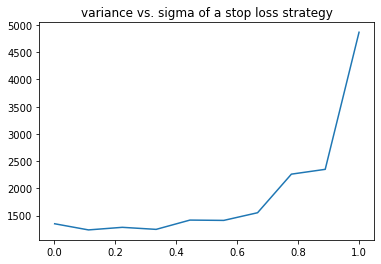

In [25]:
# stop loss strategy variance vs. change in sigma
mc_var=[]
periods = 10
sigma=np.linspace(0.001,1,periods)
#assumed interest rate is 0%
for mc in range(1,100):
    variance=[]

    for s in range(0,10):
        time=np.linspace(0.001,1,periods)
        tau=time[::-1]
        tau 
        z=[0]

        for i in range (0,len(tau)):
            z.append(np.random.randn())
        S=[100]

        r=0
        d=0
        K=100
        T=1
        C0=get_call(T=1, r=0, d=0, S0=100,K=106, sigma=sigma[s])

        action=[]
        if S[0]>=K:
            action.append(K)
        else:
            action.append(0)


        bs=[]
        pnl=[]



        #generate random stock process
        S= [100 ,S[0]*np.exp((r-0.5*sigma[s]**2)/periods + sigma[s]*z[1]/np.sqrt(periods))]
        for j in range(1,len(tau)-1):
            S.append(S[j]*np.exp((r-0.5*sigma[s]**2)/periods + sigma[s]*z[j+1]/np.sqrt(periods)))

        #stock holdings -> option underwriter:
        # buys 1 unit of stock if S=>K for each time period (covered call) *technically buy when S=K and hold S>K
        # sells 1 unit of stock if S<K and does nothing provided S stays less than K (uncovered call)
        # buying stock at price K (if S>K at time t then technically S=K before time t)
        #so make t continuous for better accuracy

        for i in range(1,len(S)):
            if S[i]==K:
                action.append('buy')
            if S[i]>K:
                if action[i-1]=='buy':
                    action.append('hold stock')
                elif action[i-1]==('hold stock'):
                    action.append('hold stock')
                else:
                    action.append('buy')
            else:
                if action[i-1]=='sell':
                    action.append('do nothing')

                elif action[i-1]=='do nothing':
                    action.append('do nothing')
                elif action[i-1]==0:
                    action.append('do nothing')

                else:
                    action.append('sell')

        #generate BS Call price evolution
        for u in range(0,periods):
            bs.append(get_call(tau[u], r, d, S[u],K, sigma[s]))

        # cash evolution
        cash=[C0]
        for c in range(1,periods):
            if action[c]=='do nothing':
                cash.append(cash[c-1])
            elif action[c]=='buy':
                cash.append(cash[c-1]-S[c])
            elif action[c]=='hold stock':
                cash.append(cash[c-1])
            else:
                cash.append(cash[c-1]+S[c])

        #value of portfolio (cash+stock value if are holding stock)
        portfolio=[cash[0]]
        for p in range(1,periods):
            if action[p]=='do nothing':
                portfolio.append(cash[p])
            elif action[p]=='buy':
                portfolio.append(cash[p]+S[c])
            elif action[p]=='hold stock':
                portfolio.append(cash[p]+S[p])
            else:
                portfolio.append(cash[p]-S[c])

        #generate pnl for each time interval        
        for h in range(0,periods):
            pnl.append(portfolio[h]-bs[h])


        variance.append(np.var(pnl))
        
    mc_var.append(variance)
   
    
mean_var=[]    
for d in range(0,len(variance)):
    intermediate_list=[]
    for g in range(0,len(mc_var)):
        intermediate_list.append(mc_var[g][d])
    mean_var.append(np.mean(intermediate_list))
    
    
                    
x=np.linspace(0,len(mean_var),len(mean_var))
plt.plot(sigma,mean_var)
plt.title('variance vs. sigma of a stop loss strategy')
plt.show()
        

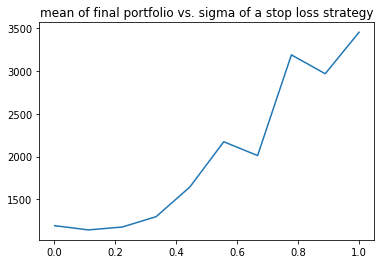

In [32]:
# stop loss strategy mean of pnl vs. change in sigma (IV)
mc_mean=[]
periods = 10
sigma=np.linspace(0.001,1,periods)
#assumed interest rate is 0%
for mc in range(1,100):
    mean=[]

    for s in range(0,10):
        time=np.linspace(0.001,1,periods)
        tau=time[::-1]
        tau 
        z=[0]

        for i in range (0,len(tau)):
            z.append(np.random.randn())
        S=[100]

        r=0
        d=0
        K=100
        T=1
        C0=get_call(T=1, r=0, d=0, S0=100,K=106, sigma=sigma[s])

        action=[]
        if S[0]>=K:
            action.append(K)
        else:
            action.append(0)


        bs=[]
        pnl=[]



        #generate random stock process
        S= [100 ,S[0]*np.exp((r-0.5*sigma[s]**2)/periods + sigma[s]*z[1]/np.sqrt(periods))]
        for j in range(1,len(tau)-1):
            S.append(S[j]*np.exp((r-0.5*sigma[s]**2)/periods + sigma[s]*z[j+1]/np.sqrt(periods)))

        #stock holdings -> option underwriter:
        # buys 1 unit of stock if S=>K for each time period (covered call) *technically buy when S=K and hold S>K
        # sells 1 unit of stock if S<K and does nothing provided S stays less than K (uncovered call)
        # buying stock at price K (if S>K at time t then technically S=K before time t)
        #so make t continuous for better accuracy

        for i in range(1,len(S)):
            if S[i]==K:
                action.append('buy')
            if S[i]>K:
                if action[i-1]=='buy':
                    action.append('hold stock')
                elif action[i-1]==('hold stock'):
                    action.append('hold stock')
                else:
                    action.append('buy')
            else:
                if action[i-1]=='sell':
                    action.append('do nothing')

                elif action[i-1]=='do nothing':
                    action.append('do nothing')
                elif action[i-1]==0:
                    action.append('do nothing')

                else:
                    action.append('sell')

        #generate BS Call price evolution
        for u in range(0,periods):
            bs.append(get_call(tau[u], r, d, S[u],K, sigma[s]))

        # cash evolution
        cash=[C0]
        for c in range(1,periods):
            if action[c]=='do nothing':
                cash.append(cash[c-1])
            elif action[c]=='buy':
                cash.append(cash[c-1]-S[c])
            elif action[c]=='hold stock':
                cash.append(cash[c-1])
            else:
                cash.append(cash[c-1]+S[c])

        #value of portfolio (cash+stock value if are holding stock)
        portfolio=[cash[0]]
        for p in range(1,periods):
            if action[p]=='do nothing':
                portfolio.append(cash[p])
            elif action[p]=='buy':
                portfolio.append(cash[p]+S[c])
            elif action[p]=='hold stock':
                portfolio.append(cash[p]+S[p])
            else:
                portfolio.append(cash[p]-S[c])

        #generate pnl for each time interval        
        for h in range(0,periods):
            pnl.append(portfolio[h]-bs[h])


        mean.append(np.mean(pnl))
        
    mc_mean.append(variance)
   
    
mean_mean=[]    
for d in range(0,len(variance)):
    intermediate_list=[]
    for g in range(0,len(mc_var)):
        intermediate_list.append(mc_var[g][d])
    mean_mean.append(np.mean(intermediate_list))
    
    
                    
x=np.linspace(0,len(mean_mean),len(mean_mean))
plt.plot(sigma,mean_mean)
plt.title('mean of final portfolio vs. sigma of a stop loss strategy')
plt.show()
        